**@juliaroquette (14 Nov 23):** Implementing extinction laws for SEDan+

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Cardelli 89

Following https://ui.adsabs.harvard.edu/abs/1989ApJ...345..245C/abstract 
)[Cardelli et al. 1989 ApJ 345 245], here I am implementing a parametrization for the extinction law for the Galaxy.

\begin{equation}
\Bigg< \frac{A_\lambda}{A_V}\Bigg>=a\Big(\frac{1}{\lambda}\Big)+\frac{b\Big(\frac{1}{\lambda}\Big)}{R_V}
\end{equation}

The definitions of $a\Big(\frac{1}{\lambda}\Big)$ and $b\Big(\frac{1}{\lambda}\Big)$ are divided into four wavelength ranges:

- FUV: $8\mu m^{-1}\leq\frac{1}{\lambda}\leq10\mu m^{-1}$ ($\sim 0.1-0.125 \mu m$)

    $a\Big(\frac{1}{\lambda}\Big)=-1.073-0.628\Big(\frac{1}{\lambda}-8\Big)+0.137\Big(\frac{1}{\lambda}-8\Big)^2-0.070\Big(\frac{1}{\lambda}-8\Big)^2$
    
    $b\Big(\frac{1}{\lambda}\Big)=13.670+4.257\Big(\frac{1}{\lambda}-8\Big)-0.420\Big(\frac{1}{\lambda}-8\Big)^2+0.374\Big(\frac{1}{\lambda}-8\Big)^3$ 
    
    
    
- UV: $3.3\mu m^{-1}\leq\frac{1}{\lambda}\leq8\mu m^{-1}$ ($\sim 0.125-0.91 \mu m$)

    $a\Big(\frac{1}{\lambda}\Big)=0.574\times\Big(\frac{1}{\lambda}\Big)^{1.61}$ 
    
    $b\Big(\frac{1}{\lambda}\Big)=-0.527\times\Big(\frac{1}{\lambda}\Big)^{1.61}$ 
    
- Optical/near-infrared: $1.1\mu m^{-1}\leq\frac{1}{\lambda}\leq3.3\mu m^{-1}$ ($\sim 0.3-0.91 \mu m$)

    $a\Big(\frac{1}{\lambda}\Big) = 1 + 0.17699y - 0.50447y^2 - 0.02427y^3 + 0.72085y^4 + 0.01979y^5 - 0.77530y^6 + 0.32999y^7$, where $y = \frac{1}{\lambda}-1.82$
    
    $b\Big(\frac{1}{\lambda}\Big) = 1.41338y + 2.28305y^2 + 1.07233y^3 - 5.38434y^4 - 0.62251y^5 + 5.30260y^6 - 2.09002y^7$ 
    
- Infrared: $0.3\mu m^{-1}\leq\frac{1}{\lambda}\leq1.1\mu m^{-1}$ ($\sim 0.91-3.3 \mu m$)

    $a\Big(\frac{1}{\lambda}\Big) =  1.752 - 0.316\Big(\frac{1}{\lambda}\Big) - \frac{0.104}{\Bigg[\Big(\frac{1}{\lambda} - 4.67\Big)^2 + 0.341\Bigg]} + F_a\Big(\frac{1}{\lambda}\Big)$, and
    
    $b\Big(\frac{1}{\lambda}\Big) = -3.090 + 1.825\Big(\frac{1}{\lambda}\Big) + \frac{1.206}{\Bigg[\Big(\frac{1}{\lambda} - 4.62\Big)^2 + 0.263\Bigg]} + F_b\Big(\frac{1}{\lambda}\Big)$, where:
    
    $F_a\Big(\frac{1}{\lambda}\Big) = - 0.04473(\frac{1}{\lambda} - 5.9)^2 - 0.009779(\frac{1}{\lambda} - 5.9)^3 $ for $8\geq\frac{1}{\lambda}\geq 5.9$
    
    $F_b\Big(\frac{1}{\lambda}\Big) = 0.2130(\frac{1}{\lambda} - 5.9)^2 + 0.1207(\frac{1}{\lambda} - 5.9)^3 $ for $8\geq\frac{1}{\lambda}\geq 5.9$
       
    $F_a\Big(\frac{1}{\lambda}\Big) = F_b\Big(\frac{1}{\lambda}\Big) = 0 $ for $\frac{1}{\lambda}< 5.9$

In [285]:
def cardeli89_Awl_Av(x, Rv=3.1):
    """
    input:
    
    - wavelength in microm
    """
    x = np.asarray(x)
   # x = 1./np.array(wavelength)
    def ax(x):
        
        # IR
        ir = (x >= 0.3) & (x <= 1.1)
        ir_result = np.where(ir, 0.574 * (x**1.61), 0)

        # OIR
        y = x - 1.82
        oir = (x > 1.1) & (x < 3.3)
        oir_result = np.where(oir, 1 + 0.17699*y - 0.50447*y**2 - 0.02427*y**3 + 0.72085*y**4\
                           + 0.01979*y**5 - 0.77530*y**6 + 0.32999*y**7, 0)

        # UV
        uv = (x >= 3.3) & (x <= 8.)
        def Fa(x):
            fa_condition = (x < 5.9)
            return np.where(uv, 0, -0.04473*(x - 5.9)**2 - 0.009779*(x - 5.9)**3)
        uv_result = np.where(uv, 1.752 - 0.316*x - 0.104/((x - 4.67)**2 + 0.341) + Fa(x), 0)

        # FUV
        fuv = (x > 8) & (x <= 10.)
        fuv_result = np.where(fuv, -1.073 - 0.628*(x - 8.) + 0.137*(x - 8.)**2 - 0.070*(x - 8.)**3 , 0)


        # Outside range
        outside = ~ir & ~oir & ~uv & ~fuv
        outside_result = np.where(outside, np.nan, 0.)

        return  ir_result + oir_result + uv_result + fuv_result + outside_result
    def bx(x):
        # IR
        ir = (x >= 0.3) & (x <= 1.1)
        ir_result = np.where(ir, -0.527*(x**1.61), 0)

        # OIR
        oir = (x > 1.1) & (x < 3.3)        
        y = x - 1.82
        oir_result = np.where(oir, 1.41338*y + 2.28305*y**2 +
                              1.07233*y**3 - 5.38434*y**4 - 0.62251*y**5 +
                              5.30260*y**6 - 2.09002*y**7 , 0)

        # UV
        uv = (x >= 3.3) & (x <= 8.)
        def Fb(x):
            fb_condition = (x < 5.9)
            return np.where(fb_condition, 0,  0.2130*(x - 5.9)**2 + 0.1207*(x - 5.9)**3)
        uv_result = np.where(uv,  -3.090 + 1.825*x + 1.206/((x- 4.62)**2 + 0.263)+ Fb(x), 0)
        
        # FUV
        fuv = (x > 8.) & (x <= 10.)
        fuv_result = np.where(fuv, 13.670 + 4.257*(x - 8) - 0.420*(x - 8)**2 + 0.374*(x - 8)**3, 0)
        

        # Outside range
        outside = ~ir & ~oir & ~uv & ~fuv
        outside_result = np.where(outside, np.nan, 0)

        return ir_result + oir_result + uv_result + fuv_result + outside_result
    return ax(x) + bx(x)/Rv

Based on Table 3 from Cardelli+89, this tests if my implementation is correct:

In [286]:
import decimal 


In [287]:
ct = decimal.getcontext().prec = 4
decimal.Decimal(0.9530, ct) == decimal.Decimal(0.9530040376911071, ct)

TypeError: optional argument must be a context

In [288]:
ft_ = ['U', 'B',  'V',  'R',  'I',  'J', 'H',  'K', 'L']
x_ = [2.78, 2.27, 1.82, 1.43, 1.11, 0.8, 0.63, 0.46, 0.29]
ax_ = [0.9530, 0.9982, 1.0000, 0.8686, 0.6800, 0.4008, 0.2693, 0.1615, 0.0800]
bx_ = [1.9090, 1.0495, 0.0000, -0.3660, -0.6239, -0.3679, -0.2473, -0.1483, -0.0734]
Av_3p1_ = [1.569, 1.337, 1.000, 0.751, 0.479, 0.282, 0.190, 0.114, 0.056]
assert len(ft) == len(x_) == len(ax_) == len(bx_) == len(Av_3p1)

In [289]:
    for i, x in enumerate(x_[:-1]):
        # assert np.isclose(ax(x), ax_[i]), 
        print("error at x = {0}, ax = {1} and found a(x) = {2}".format(x, ax_[i], ax(x)))

error at x = 2.78, ax = 0.953 and found a(x) = 0.9530040376911071
error at x = 2.27, ax = 0.9982 and found a(x) = 0.9999984200611799
error at x = 1.82, ax = 1.0 and found a(x) = 1.0
error at x = 1.43, ax = 0.8686 and found a(x) = 0.8690006402518357
error at x = 1.11, ax = 0.68 and found a(x) = 0.6790006684382455
error at x = 0.8, ax = 0.4008 and found a(x) = 0.4007622179372656
error at x = 0.63, ax = 0.2693 and found a(x) = 0.27280365019748587
error at x = 0.46, ax = 0.1615 and found a(x) = 0.16441899958991438


In [290]:
ax(np.array(x))

0.16441899958991438

In [291]:
    for i, x in enumerate(x_[:-1]):
        # assert np.isclose(ax(x), ax_[i]), 
        print("error at x = {0}, ax = {1} and found a(x) = {2}".format(x, bx_[i], bx(x)))

error at x = 2.78, ax = 1.909 and found a(x) = 1.9089955174730173
error at x = 2.27, ax = 1.0495 and found a(x) = 0.9999978251145467
error at x = 1.82, ax = 0.0 and found a(x) = 0.0
error at x = 1.43, ax = -0.366 and found a(x) = -0.3649961746445802
error at x = 1.11, ax = -0.6239 and found a(x) = -0.6229948252024011
error at x = 0.8, ax = -0.3679 and found a(x) = -0.3679471931235871
error at x = 0.63, ax = -0.2473 and found a(x) = -0.2504660690837545
error at x = 0.46, ax = -0.1483 and found a(x) = -0.15095611983255205


In [292]:
    for i, x in enumerate(x_[:-1]):
        # assert np.isclose(ax(x), ax_[i]), 
        print("error at x = {0}, ax = {1} and found a(x) = {2}".format(x, Av_3p1_[i], AlAv(x)))

error at x = 2.78, ax = 1.569 and found a(x) = 1.5688090433275643
error at x = 2.27, ax = 1.337 and found a(x) = 1.3225783636465176
error at x = 1.82, ax = 1.0 and found a(x) = 1.0
error at x = 1.43, ax = 0.751 and found a(x) = 0.751259938753584
error at x = 1.11, ax = 0.479 and found a(x) = 0.47803459579230967
error at x = 0.8, ax = 0.282 and found a(x) = 0.28206957499417296
error at x = 0.63, ax = 0.19 and found a(x) = 0.192008144041436
error at x = 0.46, ax = 0.114 and found a(x) = 0.11572347706328467


In [293]:
ax(x), x

(0.16441899958991438, 0.46)

In [294]:
x = np.linspace(0.1, 10, 100)

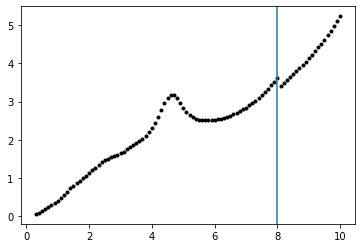

In [296]:
plt.plot(x, cardeli89_Awl_Av(x), 'k.')
plt.axvline(8)